# Background: Polymer posterior samples

This notebook delves deeper into the core component of the likelihood evaluation: Polymer posterior samples. 

In [45]:
import sys,os
# add the path to the library and load it
sys.path.insert(0, os.path.abspath("../../"))
from EPlink import Polymer_inference
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

## Introduction
In this library, we model the case where polymer contacts, possible at a large distance, drives transcription. The central assumption is that the polymer conformation can affect transcription, but transcription can't affect the polymer conformation. The causal structure is therefore something like this: 

![Example Image](./../Figures/Model_logical_structure.png)


What this means is that we can use the time series of observed enhancer-promoter (EP) distances to infer the position of the polymer independelty of the observed transcript intensity data. This is because we know that that data is downstream of the polymer dynamics and won't affect it. 

Once we have the inference of the polymer configuration we can use it as an input in a likelihood calculation for the observed transcript intensity. This likelihood will depend on the parameters of the transcription model which links EP-distances to transcription and thus allows fitting by maximizing the likelihood with respect to those parameters. 

The above ideas can be phrased mathematically if we introduce variable names for the various quantities: 
- Observed EP distance: $X$
- Polymer configuration: $Y$
- Transcription model: $\theta$
- Observed transcript intensity $ I $

%%latex
Then the likelihood can be written as:
\begin{align}\nonumber
P(X,I|\theta) &= \int P(X,I,Y|\theta) dY\,, \\\nonumber
&= \int P(I,Y|X,\theta)P(X) dY\,,\\\nonumber
&= \int P(I|Y,X,\theta)P(Y|X,\theta)P(X) dY\,,\\\nonumber
&= \int P(I|Y,\theta)P(Y|X)P(X) dY\,,\\\nonumber
&\propto \int P(I|Y,\theta)P(Y|X) dY\,.\\\nonumber
&\equiv \int \mathcal{L}[\theta]_Y P(Y|X) dY\,,\\\nonumber
\end{align}

where the fourth line follows from the third from the dependency graph above. The last line shows that we can write the likelihood as the integral over the conditional likelihood knowing the true polymer configuration weighted by the probability of that likelihood occuring knowing the EP data $P(Y|X)$. If we were able to obtain samples from $P(Y|X)$. We could approximate the integral by a sum over such samples
$$
P(X,I|\theta) \approx \frac{1}{N}\sum_{i=1}^N \mathcal{L}[\theta]_{Y_i}\,,  
$$
where $Y_i$ are samples from $P(Y|X)$. In this notebook we will show how to obtain such samples and then later, we will use those samples to calculate and extremize the likelihood.

## Polymer posterior samples
The above section describes the dynamics inherent in the Rouse model. Given this background, we now tackle the question of how to infer where the polymer was given a noisy measurement of parts of the polymer beads. The measurements we seek are of the form 
$$
∆x = \vec{w}\cdot \vec{x} + \epsilon\,,
$$
where $\vec{x}$ is the true x-components of the polymer beads $\vec{w}$ is a projection vector and $\epsilon$ is a vector of noise. For enhancer-promoter measurements $\vec{w}$ would be 1 at the enhancer bead and -1 at the promoter bead and we would have both an x,y, and z component. The inference is completely independent of the y and z components and we can therefore focus on the x-components and just know to repeat the same procedure for the other components. 

Let's generate some example data to work with in what follows

[Text(0.5, 0, 'Time'), Text(0, 0.5, '∆x')]

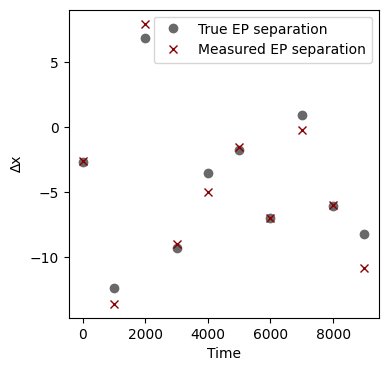

In [46]:
#parameters
D = 1
k = 1
dt = 1000/k
N = 100
nsteps = 10
measurement_error = np.array([1])

#make the projection vector
w = np.zeros(N)
w[N//3] = 1 # promoter position
w[2*N//3] = -1 # enhancer position 

#Generate the EP measurement
times,traj = Polymer_inference.Generate_trajectory(nsteps,dt,1,k,D,N) #generate the polymer trajectory
ep_traj, ep_traj_w_err = Polymer_inference.Generate_measurements(traj,w,measurement_error)

fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(times,ep_traj[0],"o",label="True EP separation",color="dimgrey")
ax.plot(times,ep_traj_w_err[0],"x",label="Measured EP separation",color="darkred")
ax.legend()
ax.set(xlabel="Time",ylabel="∆x")


For inference of transcription mediated by enhancer-promoter contacts, we need to know when the pair was in contact. This could have happened between measurements, and with the noisiness of the measurements we don't know how certain we are of contacts. For this reason, we want to be able to generate high temporal resolution trajectory consistent with the observations. In effect this means that we seek to generate samples from the posterior distribution of the polymer configuration given the observed EP distances.

Due to the Gaussianity of the Rouse model, this turns out to be a fully solvable problem, and the end result (see [Opper & Archambeau 2011](https://www.cambridge.org/core/books/abs/bayesian-time-series-models/approximate-inference-for-continuoustime-markov-processes/D953508FAF444E14B5331436E8433812) or [Koeppl & Wildner 2021](https://arxiv.org/abs/2103.00988)) is that the dynamics of of the posterior samples (backward in time) obey the stochastic differential equation 
$$
\dot{\vec{a}} = kA \vec{a} +D\nabla\log\beta+ \sqrt{2D}\vec{\xi}\,,
$$
i.e. the same equation as for the original system (with the drift term reversed) but with an additional drift term. The term $\nabla\log\beta$ is the gradient of the log of the so-called [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter) density. The Kalman filter is a recursive algorithm to arrive at the optimal estimate of the state of a linear dynamical system given noisy measurements. The Kalman filter density is a Gaussian and the gradient of its log is therefore a linear function of the state. So the additional drift term is akin to a spring force that pulls the polymer towards the most likely state given the measurements.

To get a sense of what the Kalman filter does, we can compute it and plot it using the PosteriorSampler

Running the forward filter


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 562.20it/s]


[Text(0.5, 0, 'Time'), Text(0, 0.5, '∆x'), (-25.0, 10.0)]

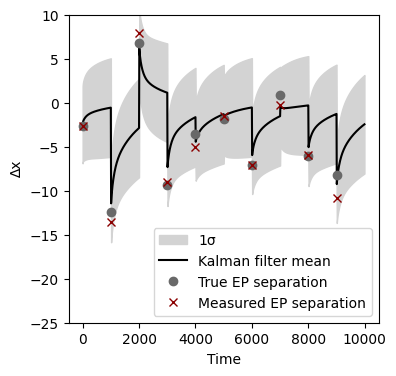

In [47]:
#Initialize the posterior sampler. This will run the Kalman filter calculation at the datapoints.
# When we then later ask for the Kalman filter at a time between the datapoints, the filter will interpolate between the datapoints on the fly (FYI, interpolation here does not mean that the filter values are approximated between datapoints, they are evaluated explicitly).
PS = Polymer_inference.PosteriorSampler(N,k,D,ep_traj_w_err,times,measurement_error,w)

#sample times on a finer grid to see the behaviour between measurements
fine_dt = dt/100
fine_times = np.arange(0,nsteps*dt,fine_dt)

#Use the PS.forward_filter __getitem__ method to get the means and variances of the Kalman filter at each time
Kalman_means,Kalman_vars = [],[]
for t in fine_times:
    m,v = PS.forward_filter[t]
    Kalman_means.append(m)
    Kalman_vars.append(v)
# The means and covariances are for the full polymer in the Rouse mode basis. We only want the parts for the EP separation, so we project using the projection vector and the Q matrix (referred to here as the M matrix)
Kalman_means = np.array(Kalman_means)@PS.M_matrix
Kalman_vars = PS.M_matrix.T@np.array(Kalman_vars)@PS.M_matrix
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.fill_between(fine_times,Kalman_means[:,0]-np.sqrt(Kalman_vars[:,0]),Kalman_means[:,0]+np.sqrt(Kalman_vars[:,0]),color="lightgrey",label="1σ")
ax.plot(fine_times,Kalman_means[:,0],label="Kalman filter mean",color="black")
ax.plot(times,ep_traj[0],"o",label="True EP separation",color="dimgrey")
ax.plot(times,ep_traj_w_err[0],"x",label="Measured EP separation",color="darkred")
ax.legend()
ax.set(xlabel="Time",ylabel="∆x",ylim=(-25,10))

We see that the Kalman filter jumps at the measurement as new information is incorporated and progresses smoothly between measurements. It can be shown that the Kalman filter is the optimal estimate of the dynamical system given past observations. As such, it means that the only thing that goes into calculating the Kalman estimate at time $t$ is all prior measurements. It is therefore not surprising that new datapoints make the estimate change drastically. 

If we now think about the drift term in the equation for the dynmaics of the posterior samples, we need to view the above plot backwards in time. Right after a measurement, the Kalman filter is very uncertain about where the polymer is and the drift term is very small (the standard deviation is inversely proportional to the "data spring constant"). In this regime, the dynamics are dominated by the original Rouse dynamics backwards in time and the EP separation will grow exponentially (backwards) in time. As the polymer gets closer to the next measurement, the Kalman filter becomes more certain and the drift term becomes more important. The polymer will then be pulled towards the most likely state given the measurements. To see this explicitly, we generate a bunch of trajectories using the posterior sampler object and plot them.

In [68]:
nsamples = 10000
# notice that we choose a very fine spacing fot the samples, this is because the sampler is numerically integrating the posterior stochastic differential equation and will therefore blow up if the spacing is too large.
samp_times,samples = PS.sample(nsamples,k/10,verbose=True)

Computing the paths


100%|██████████| 89999/89999 [02:45<00:00, 544.15it/s]


[Text(0.5, 0, 'Time'), Text(0, 0.5, '∆x'), (-30.0, 10.0)]

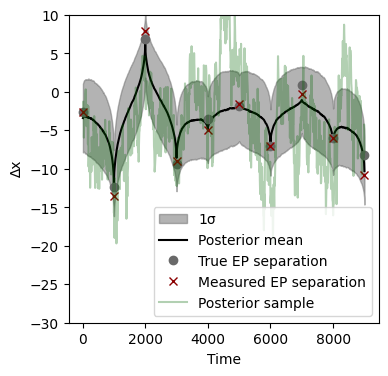

In [69]:

ms,stds = np.mean(samples[0],axis=0),np.std(samples[0],axis=0)
sampling_interval = 100
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.fill_between(samp_times[::sampling_interval],ms[::sampling_interval]-stds[::sampling_interval],ms[::sampling_interval]+stds[::sampling_interval],color="dimgrey",label="1σ",alpha=0.5)
ax.plot(samp_times[::sampling_interval],ms[::sampling_interval],label="Posterior mean",color="black")
ax.plot(times,ep_traj[0],"o",label="True EP separation",color="dimgrey")
ax.plot(times,ep_traj_w_err[0],"x",label="Measured EP separation",color="darkred")
ax.plot(samp_times[::sampling_interval],samples[0,0][::sampling_interval],color="darkgreen",alpha=0.3,label="Posterior sample")
ax.legend()
ax.set(xlabel="Time",ylabel="∆x",ylim=(-30,10))

Notice how the trajectory seems quite free, but does get close to all the measurements. When looking at the distribution, it becomes clear that the trajectory is most free ($\sigma$ is biggest) right between the measurements as is expected.